In [2]:
from qutip import *
import numpy as np
from itertools import product
import random
import matplotlib.pyplot as plt

In [102]:
class pauli_transfer_matrix():
    def __init__(self, ntls):
        self.ntls = ntls
        self.pauli_index = [0,1,2,3]
        self.pauli_index_ls = [self.pauli_index] * self.ntls
        self.u_perm = list(product(*self.pauli_index_ls))
        self.pauli_ls = [qeye(2), sigmax(), sigmay(), sigmaz()]
    
    def perm_vec(self):
        return list(product(*self.pauli_index_ls))
    
    def pauli_gen(self, index):
        return tensor([self.pauli_ls[index[i]] for i in range(len(index))])
    
    def pauli_qutip_ops(self):
        return {index: self.pauli_gen(index) for index in self.u_perm}
    
    # Pauli product based on indexes
    def pauli_commute(self, u, w):
        # u, w: tuples, e.g. (0,1,2,2,3) for n=5
        # Determine 0 or 2
        sgn = 1
        for i in range(len(u)):
            sgn *= (-1) ** self.delta(u[i], w[i])
        if sgn == (-1) ** self.ntls:
            return (0, 0)
        else:
            (fact, op) = self.pauli_prod(u, w)
            return (2 * fact, op)
    
    @staticmethod
    def delta(a, b):
        if a == b or a == 0 or b == 0:
            return 1
        else:
            return 0

    @staticmethod
    def pauli_prod_single(p1, p2):
        results = {
            (1,2): (1j, 3),
            (1,3): (-1j, 2),
            (2,1): (-1j, 3),
            (2,3): (1j, 1),
            (3,1): (1j, 2),
            (3,2): (-1j, 1)
        }
        if p1 == p2:
            return (1, 0)
        elif p1 == 0:
            return (1, p2)
        elif p2 == 0:
            return (1, p1)
        
        else:
            return results[(p1,p2)]

    def pauli_prod(self, u, w):
        new = np.zeros(len(u))
        fact_new = 1
        for i in range(len(u)):
            (fact, res) = self.pauli_prod_single(u[i], w[i])
            fact_new *= fact
            new[i] = res
        return (fact_new, tuple(new.astype(int)))
    
    def gamma_u_w(self, u, D, w):
        # D = [(df, d)], df constant factor, d pauli vector (tuple)
        # [u,d]=v return 0/2 if w=v, else 0
        # d be an index for a Pauli matrix in diagonal D
        for D_loc in D:
            (df, d) = D_loc
            (fact, v) = self.pauli_commute(u,d)
            if v != w:
                continue
            else:
                return df * fact
        return 0
    
    def gamma_distibution(self, D):
        pair_index_ls = [self.u_perm] * 2
        # For ntls = 2, len(pair_perm)=16^ntls=256
        perm_pair_uw = list(product(*pair_index_ls))
        gamma = [np.abs(self.gamma_u_w(pair_uw[0], D, pair_uw[1])) for pair_uw in perm_pair_uw]
        gamma = gamma/np.sum(gamma)
        return perm_pair_uw, gamma

    def sample_uw(self, D, show=False):
        (perm_pair_uw, gamma_ls) = self.gamma_distibution(D)
        if show:
            samples = np.random.choice(len(perm_pair_uw),500000, p=gamma_ls)
            sample_stat = np.unique(samples, return_counts=True)
            unique_ind = list(sample_stat[0].astype(int))
            ind_occur = sample_stat[1]
            plt.bar(unique_ind, ind_occur)
            plt.show()
            all_possible_uw = [(perm_pair_uw[i], gamma_ls[i]) for i in unique_ind]
            return all_possible_uw
        else:
            sample = np.random.choice(len(perm_pair_uw), p=gamma_ls)
            return (perm_pair_uw[sample], gamma_ls[sample])

    def sample_vv(self):
        (v, vp) = (self.u_perm[random.randint(0,len(self.u_perm)-1)], 
           self.u_perm[random.randint(0,len(self.u_perm)-1)])
        return (v, vp)
    


In [103]:
# Test 1 Pauli commutators

# Initialize class
sys = pauli_transfer_matrix(2)
# [X1X2, Z1] = -2iY1X2
qutip_ops = sys.pauli_qutip_ops()
comm_qutip = commutator(qutip_ops[(1,1)], qutip_ops[(3,0)])
print('Qutip results:', comm_qutip)
print('Pauli_commute:', sys.pauli_commute((1,1),(3,0)))

Qutip results: Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.  0.  0. -2.]
 [ 0.  0. -2.  0.]
 [ 0.  2.  0.  0.]
 [ 2.  0.  0.  0.]]
Pauli_commute: (-2j, (2, 1))


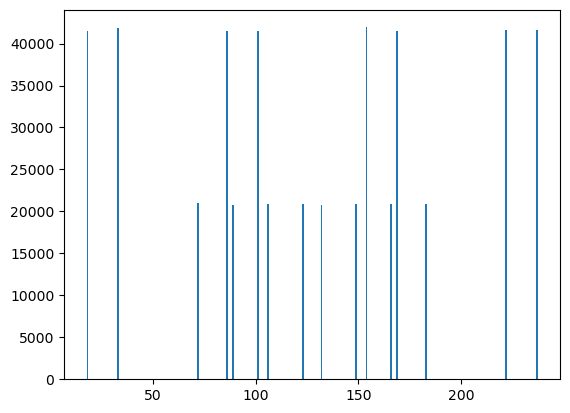

[(((0, 1), (0, 2)), 0.08333333333333333), (((0, 2), (0, 1)), 0.08333333333333333), (((1, 0), (2, 0)), 0.041666666666666664), (((1, 1), (1, 2)), 0.08333333333333333), (((1, 1), (2, 1)), 0.041666666666666664), (((1, 2), (1, 1)), 0.08333333333333333), (((1, 2), (2, 2)), 0.041666666666666664), (((1, 3), (2, 3)), 0.041666666666666664), (((2, 0), (1, 0)), 0.041666666666666664), (((2, 1), (1, 1)), 0.041666666666666664), (((2, 1), (2, 2)), 0.08333333333333333), (((2, 2), (1, 2)), 0.041666666666666664), (((2, 2), (2, 1)), 0.08333333333333333), (((2, 3), (1, 3)), 0.041666666666666664), (((3, 1), (3, 2)), 0.08333333333333333), (((3, 2), (3, 1)), 0.08333333333333333)]
((3, 1), (0, 3))


In [104]:
# Test 2 Sampling u,w
D = [(1,(3,0)),(2,(0,3))]
print(sys.sample_uw(D, show=True))
print(sys.sample_vv())